In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

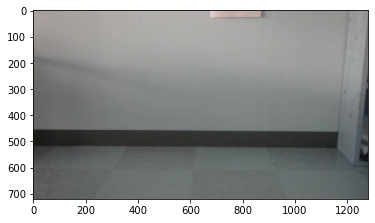

In [2]:
cap = cv2.VideoCapture("./data/edgetest/0lights.mp4")
_, frame1 = cap.read()
plt.imshow(frame1)

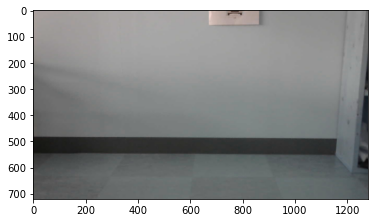

In [3]:
cap = cv2.VideoCapture("./data/edgetest/1lights.mp4")
_, frame2 = cap.read()
plt.imshow(frame2)

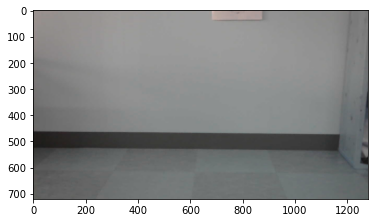

In [4]:
cap = cv2.VideoCapture("./data/edgetest/2lights.mp4")
_, frame = cap.read()
plt.imshow(frame)

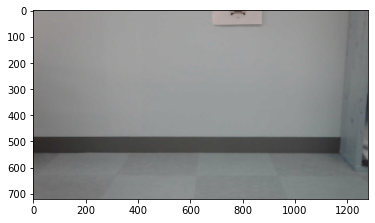

In [5]:
cap = cv2.VideoCapture("./data/edgetest/alllights.mp4")
_, frame = cap.read()
plt.imshow(frame)

## Calibration 

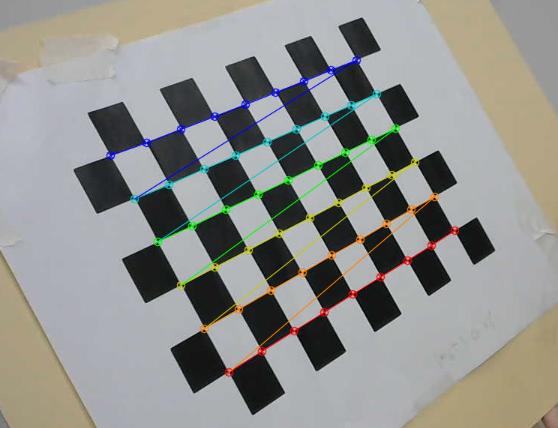

In [6]:
rms = 1.490716
fx = 1475.090993
fy = 1489.662708
cx = 685.105855
cy = 454.160610
k1 = 0.154561
k2 = -1.449785
p1 = 0.027347
p2 = 0.002975

In [7]:
# 이미지 불러오기
img1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# SIFT로 특징점 검출 및 기술자 생성
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# FLANN 매처를 사용한 특징점 매칭
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Lowe의 비율 테스트를 사용하여 좋은 매칭 필터링
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# 삼각 측량을 위한 특징점 좌표 추출
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

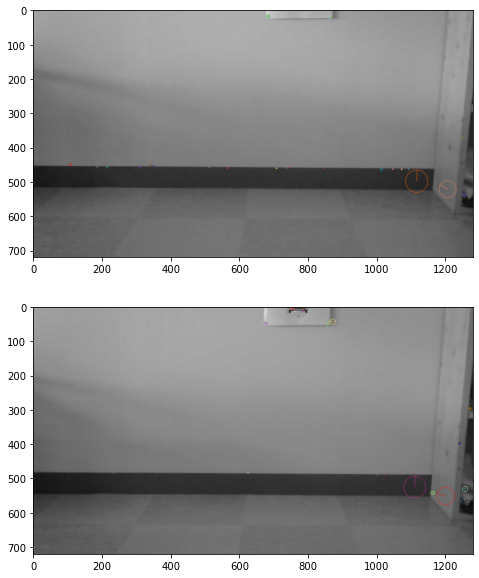

In [8]:
# 첫 번째 이미지에 특징점 표시
img1_keypoints = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 두 번째 이미지에 특징점 표시
img2_keypoints = cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 두 이미지 간의 좋은 매칭을 시각화
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# 결과 이미지 표시
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(img1_keypoints)
plt.subplot(212)
plt.imshow(img2_keypoints)

In [9]:
# 카메라 내부 매개변수 (예시)
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])  # f는 초점 거리, cx, cy는 주점 좌표

# 외부 매개변수 (예시)
R = np.eye(3)  # 회전 행렬
t = np.zeros((3, 1))  # 이동 벡터

# 투영 행렬 생성
P1 = np.dot(K, np.hstack((R, t)))
P2 = np.dot(K, np.hstack((R, t + np.array([[1], [0], [0]]))))  # 두 번째 카메라의 위치가 약간 이동했다고 가정

# 삼각 측량 수행
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# 동차 좌표에서 일반 좌표로 변환
points_3d = points_4d_hom / points_4d_hom[3]
points_3d = points_3d[:3].T

# 결과 확인
print(points_3d)

[[-1.1173565e+00  2.9224779e-02  2.8796368e+00]
 [-1.2125058e+00  5.1773071e-02  5.2120414e+00]
 [-1.2185663e+00  5.5211917e-02  5.3602309e+00]
 [ 1.5350460e-01  6.2147720e+01 -2.2123975e+02]
 [ 1.5350460e-01  6.2147720e+01 -2.2123975e+02]
 [-4.9929243e-01 -1.4143878e-01 -1.2265832e+01]
 [-2.6938412e+01  6.1860828e+01 -2.2342853e+02]
 [-1.9538755e+01  4.4227966e+01 -1.5765709e+02]
 [-7.3667297e+01 -9.8525143e+00 -2.5221657e+02]
 [-8.1699791e+01 -1.2847573e+01 -2.3144200e+02]
 [-7.1274818e+01  8.6466541e+00 -1.8663307e+02]
 [-8.3457794e+01 -1.4341636e+01 -2.1616832e+02]
 [-8.3457794e+01 -1.4341636e+01 -2.1616832e+02]]


In [10]:
# 투영 매트릭스
P = np.dot(K, np.hstack((R, t)))

# 3D 점을 2D로 투영
points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]

# 투영된 2D 점들을 출력
for point in points_2d:
    print(point)

[[112.74111 469.27887]]
[[341.94733 468.95798]]
[[349.76654 469.50458]]
[[684.0824   35.70442]]
[[684.0824   35.70442]]
[[745.1508 471.3381]]
[[862.95514  41.71655]]
[[867.9168   36.26153]]
[[1115.9497   512.35236]]
[[1205.8179  536.8533]]
[[1248.4403  385.145 ]]
[[1254.6057   552.99194]]
[[1254.6057   552.99194]]


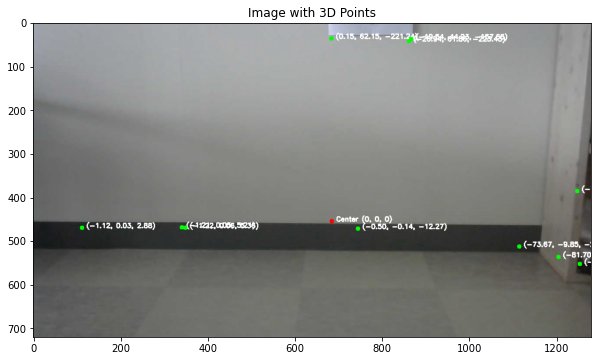

In [11]:
cap = cv2.VideoCapture("./data/edgetest/0lights.mp4")
_, frame1 = cap.read()
# plt.imshow(frame1)

# 중심 좌표(0, 0, 0)를 2D로 투영
center_point_3d = np.array([[0.0, 0.0, 0.0]])
center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


# 3D 점을 2D로 투영
points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]

# 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
for i, point in enumerate(points_2d):
    x, y = int(point[0][0]), int(point[0][1])
    cv2.circle(frame1, (x, y), 5, (0, 255, 0), -1)
    
    # 3D 좌표 텍스트로 표시
    text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
    cv2.putText(frame1, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
cv2.circle(frame1, (x_center, y_center), 5, (0, 0, 255), -1)
cv2.putText(frame1, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    
    
# 이미지 표시
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title('Image with 3D Points')
plt.show()

In [12]:
# 3D 좌표
points_3d[0]

array([-1.1173565 ,  0.02922478,  2.8796368 ], dtype=float32)

Average brightness:125.18
Bright Contrast:28.61
Threshold (lower) 91 (upper) 180


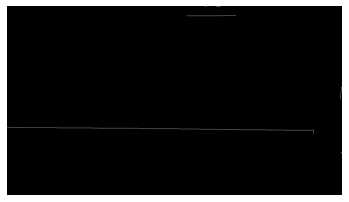

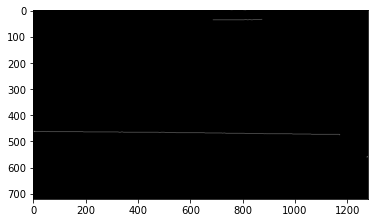

In [13]:
cap = cv2.VideoCapture("./data/edgetest/2lights.mp4")
_, frame1 = cap.read()

def edge_detection(image):
    
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
    edges = cv2.Canny(image, 100, 200)  # Canny 에지 검출 사용
    return edges

def auto_canny(img, sigma=0.33) : 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray, (5, 5), 0)
    v = np.median(gray)
    print(f"Average brightness:{np.mean(gray):.2f}") # 평균 밝기 계산 
    print(f"Bright Contrast:{np.std(gray):.2f}") # 대조 값
    lower = int(max(0, 1.0 - sigma)*v)
    upper = int(min(255, (1.0 + sigma)*v ))
    print(f"Threshold (lower) {lower} (upper) {upper}")
    edged = cv2.Canny(gray, lower, upper)
    return edged

plt.imshow(auto_canny(frame1), cmap='gray')
plt.axis('off')
plt.show()

f1_edge = edge_detection(frame1)
plt.imshow(f1_edge,cmap='gray')

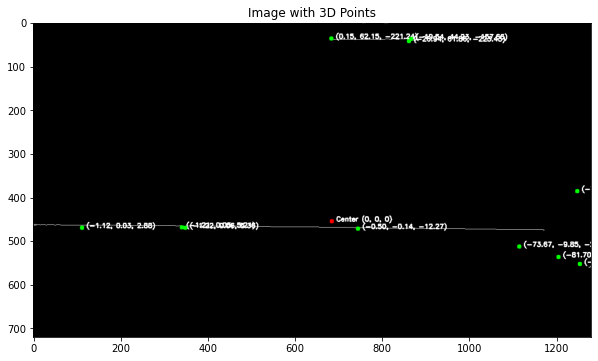

In [14]:
f1_edge = cv2.cvtColor(f1_edge , cv2.COLOR_GRAY2BGR)

# 중심 좌표(0, 0, 0)를 2D로 투영
center_point_3d = np.array([[0.0, 0.0, 0.0]])
center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


# 3D 점을 2D로 투영
points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]

# 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
for i, point in enumerate(points_2d):
    x, y = int(point[0][0]), int(point[0][1])
    cv2.circle(f1_edge, (x, y), 5, (0, 255, 0), -1)
    
    # 3D 좌표 텍스트로 표시
    text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
    cv2.putText(f1_edge, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
cv2.circle(f1_edge, (x_center, y_center), 5, (0, 0, 255), -1)
cv2.putText(f1_edge, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    
    
# 이미지 표시
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(f1_edge, cv2.COLOR_BGR2RGB))
plt.title('Image with 3D Points')
plt.show()

---
## 원하는 point의 3d 좌표 찾기

In [16]:
# 마우스 클릭 이벤트 처리 함수
def select_points(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        params.append((x, y))

# 이미지에서 좌표 선택
def get_points(image):
    points = []
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", select_points, points)

    while True:
        cv2.imshow("Image", image)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC 키
            break

    cv2.destroyAllWindows()
    return points

# # 두 이미지 불러오기
# cap = cv2.VideoCapture("./data/edgetest/2lights.mp4")
# _, frame1 = cap.read()

# cap = cv2.VideoCapture("./data/edgetest/alllights.mp4")
# _, frame2 = cap.read()

# # 각 이미지에서 좌표 선택
# points1 = get_points(frame1)
# points2 = get_points(frame2)

# # 좌표 변환
# pts1 = np.float32(points1)
# pts2 = np.float32(points2)

# # 카메라 내부 매개변수 및 외부 매개변수 정의 (여기서는 예시 값 사용)
# K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
# R = np.eye(3)
# t = np.zeros((3, 1))

# # 투영 행렬 생성
# P1 = np.dot(K, np.hstack((R, t)))
# P2 = np.dot(K, np.hstack((R, t + np.array([[1], [0], [0]])))) 

# # 삼각 측량 수행
# points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# # 동차 좌표에서 일반 좌표로 변환
# points_3d = points_4d_hom / points_4d_hom[3]
# points_3d = points_3d[:3].T

# # 결과 출력
# print(points_3d)

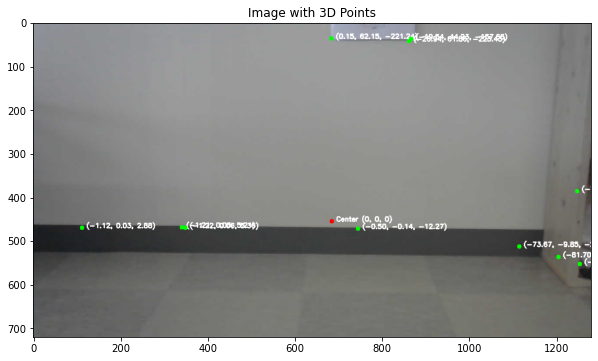

In [17]:
# 중심 좌표(0, 0, 0)를 2D로 투영
center_point_3d = np.array([[0.0, 0.0, 0.0]])
center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


# 3D 점을 2D로 투영
points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]

# 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
for i, point in enumerate(points_2d):
    x, y = int(point[0][0]), int(point[0][1])
    cv2.circle(frame1, (x, y), 5, (0, 255, 0), -1)
    
    # 3D 좌표 텍스트로 표시
    text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
    cv2.putText(frame1, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
cv2.circle(frame1, (x_center, y_center), 5, (0, 0, 255), -1)
cv2.putText(frame1, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    
    
# 이미지 표시
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title('Image with 3D Points')
plt.show()

In [18]:
def detect_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    corners = cv2.goodFeaturesToTrack(edges, maxCorners=100, qualityLevel=0.01, minDistance=30)
    return np.int0(corners)

corners1 = detect_corners(frame1)
corners2 = detect_corners(frame2)



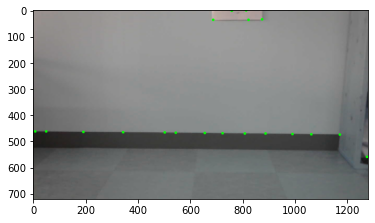

In [19]:
# 두 이미지 불러오기
cap = cv2.VideoCapture("./data/edgetest/2lights.mp4")
_, frame1 = cap.read()

cap = cv2.VideoCapture("./data/edgetest/alllights.mp4")
_, frame2 = cap.read()

corners1 = detect_corners(frame1)

# 코너점 시각화
for corner in corners1:
    x, y = corner.ravel()
    cv2.circle(frame1, (x, y), 5, (0, 255, 0), -1)
    

plt.imshow(frame1)

In [20]:
# 좌표 변환
pts1 = np.float32([corner.ravel() for corner in corners1])
pts2 = np.float32([corner.ravel() for corner in corners2])

# 카메라 내부 매개변수 및 외부 매개변수 정의 (여기서는 예시 값 사용)
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
R = np.eye(3)
t = np.zeros((3, 1))

# 투영 행렬 생성
P1 = np.dot(K, np.hstack((R, t)))
P2 = np.dot(K, np.hstack((R, t + np.array([[1], [0], [0]])))) 

# 삼각 측량 수행
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# 동차 좌표에서 일반 좌표로 변환
points_3d = points_4d_hom / points_4d_hom[3]
points_3d = points_3d[:3].T

# 결과 출력
print(points_3d)

[[-1.14509714e+00  4.70773458e-01 -3.20085716e+00]
 [-5.80965662e+00 -6.64862573e-01 -1.44852285e+01]
 [ 2.14903998e+00 -7.06042528e+00  2.45868549e+01]
 [ 2.40314640e-02 -3.52440929e+00  1.22903748e+01]
 [ 4.45866972e-01 -5.87415099e-01  3.57499671e+00]
 [ 6.52990267e-02 -1.09659813e-01  2.64317250e+00]
 [-9.63419914e-01 -2.80881196e-01  2.11591339e+00]
 [-4.16634530e-01 -4.54197191e-02 -3.02868247e+00]
 [ 1.75957716e+00 -1.00488653e+01  3.51163788e+01]
 [-1.57387419e+01 -1.00376940e+00 -6.14336929e+01]
 [-1.47057605e+00 -1.11102335e-01 -7.09114027e+00]
 [-1.21458375e+00 -2.16848582e-01 -1.44598932e+01]
 [-3.23332810e+00  2.34727478e+00  1.63854675e+02]
 [-1.61022604e+00  2.37147138e-01  1.69515133e+01]
 [ 7.34221756e-01 -8.12074170e-02 -5.94746876e+00]
 [ 2.84284639e+00 -1.63726360e-01 -1.22931519e+01]
 [-1.62720072e+00  6.15555458e-02  4.86714792e+00]
 [-5.35094082e-01 -3.67797501e-02  1.16095102e+00]
 [-1.45132220e+00  4.24822903e+00 -1.55231867e+01]]


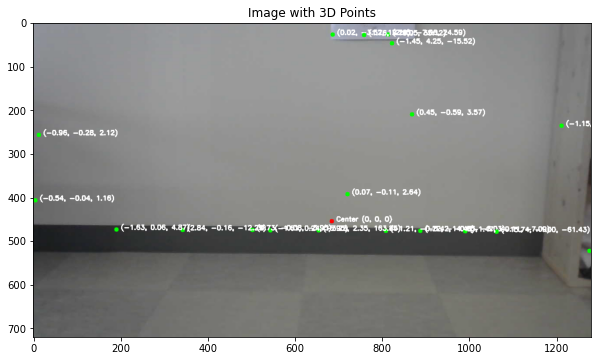

In [21]:
cap = cv2.VideoCapture("./data/edgetest/2lights.mp4")
_, frame1 = cap.read()

# 중심 좌표(0, 0, 0)를 2D로 투영
center_point_3d = np.array([[0.0, 0.0, 0.0]])
center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


# 3D 점을 2D로 투영
points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]

# 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
for i, point in enumerate(points_2d):
    x, y = int(point[0][0]), int(point[0][1])
    cv2.circle(frame1, (x, y), 5, (0, 255, 0), -1)
    
    # 3D 좌표 텍스트로 표시
    text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
    cv2.putText(frame1, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
cv2.circle(frame1, (x_center, y_center), 5, (0, 0, 255), -1)
cv2.putText(frame1, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    
    
# 이미지 표시
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title('Image with 3D Points')
plt.show()

---

## 새로 받은 데이터에 적용 

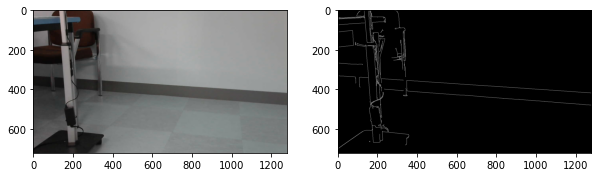

In [22]:
cap = cv2.VideoCapture("./data/edgetest2/light1.mp4")
_, frame1 = cap.read()

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(frame1)


edge_1 = cv2.Canny(frame1, 50, 150)
plt.subplot(122)
plt.imshow(edge_1, cmap='gray')

plt.show()

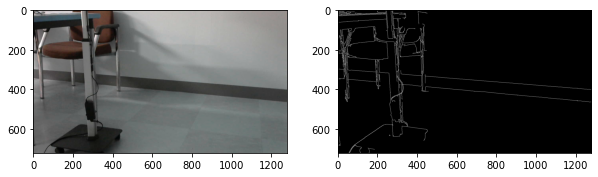

In [23]:
cap = cv2.VideoCapture("./data/edgetest2/light2.mp4")
_, frame2 = cap.read()

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(frame2)


edge_2 = cv2.Canny(frame2, 50, 150)
plt.subplot(122)
plt.imshow(edge_2, cmap='gray')

plt.show()

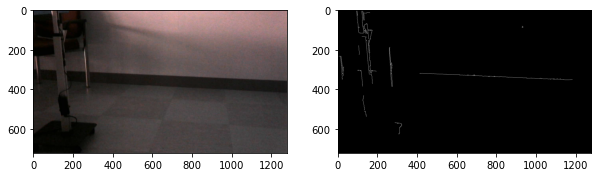

In [24]:
cap = cv2.VideoCapture("./data/edgetest2/light3.mp4")
_, frame3 = cap.read()

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(frame3)


edge_3 = cv2.Canny(frame3, 50, 150)
plt.subplot(122)
plt.imshow(edge_3, cmap='gray')

plt.show()

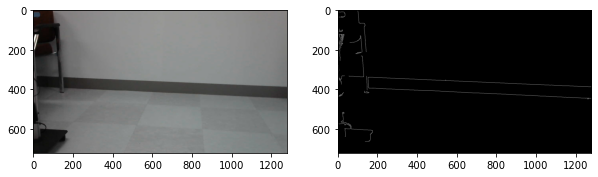

In [25]:
cap = cv2.VideoCapture("./data/edgetest2/lightall.mp4")
_, frame4 = cap.read()

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(frame4)


edge_4 = cv2.Canny(frame4, 50, 150)
plt.subplot(122)
plt.imshow(edge_4, cmap='gray')

plt.show()

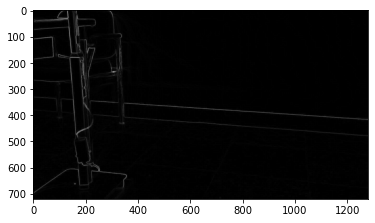

In [26]:
cap = cv2.VideoCapture("./data/edgetest2/light1.mp4")
_, frame1 = cap.read()


gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.sqrt(grad_x**2 + grad_y**2)

plt.imshow(magnitude, cmap='gray')

In [27]:
def calculate_weighted_gradient(image):
    # 색상 채널 분리
    blue, green, red = cv2.split(image)

    # Sobel 연산자를 각 채널에 적용하여 그래디언트 계산
    grad_x_red = cv2.Sobel(red, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_red = cv2.Sobel(red, cv2.CV_64F, 0, 1, ksize=3)
    
    grad_x_green = cv2.Sobel(green, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_green = cv2.Sobel(green, cv2.CV_64F, 0, 1, ksize=3)
    
    grad_x_blue = cv2.Sobel(blue, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_blue = cv2.Sobel(blue, cv2.CV_64F, 0, 1, ksize=3)

    # 각 채널에 대한 그래디언트 크기 계산
    magnitude_red = np.sqrt(grad_x_red**2 + grad_y_red**2)
    magnitude_green = np.sqrt(grad_x_green**2 + grad_y_green**2)
    magnitude_blue = np.sqrt(grad_x_blue**2 + grad_y_blue**2)

    # 가중치 적용 (예를 들어, 녹색 채널에 더 큰 가중치)
    weighted_magnitude = 0.1 * magnitude_red + 0.6 * magnitude_green + 0.2 * magnitude_blue

     # Canny 엣지 검출을 위한 임계값 설정
    lower_threshold = 100  # 임계값을 조정하여 엣지를 더 진하게 만들 수 있습니다.
    upper_threshold = 200
    blurred = cv2.GaussianBlur(weighted_magnitude, (3, 3), 0)
    # Canny 엣지 검출 적용
    edges = cv2.Canny(blurred.astype(np.uint8), lower_threshold, upper_threshold)

    return edges

In [28]:
def detect_corners(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray, 100, 200)
    edges = calculate_weighted_gradient(image)
    corners = cv2.goodFeaturesToTrack(edges, maxCorners=100, qualityLevel=0.01, minDistance=30)
    return np.int0(corners)



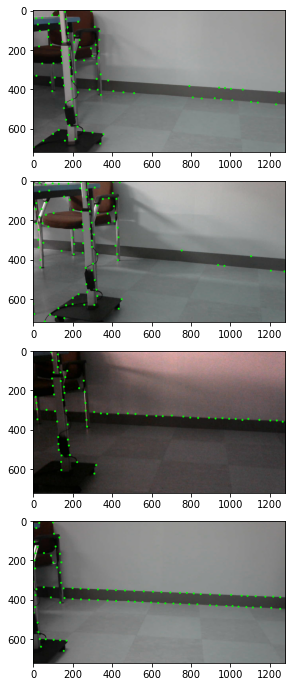

In [29]:
cap = cv2.VideoCapture("./data/edgetest2/light1.mp4")
_, frame1 = cap.read()

cap = cv2.VideoCapture("./data/edgetest2/light2.mp4")
_, frame2 = cap.read()

cap = cv2.VideoCapture("./data/edgetest2/light3.mp4")
_, frame3 = cap.read()

cap = cv2.VideoCapture("./data/edgetest2/lightall.mp4")
_, frame4 = cap.read()

edge1 = calculate_weighted_gradient(frame1)
edge2 = calculate_weighted_gradient(frame2)
edge3 = calculate_weighted_gradient(frame3)
edge4 = calculate_weighted_gradient(frame4)

corners1 = detect_corners(frame1)
corners2 = detect_corners(frame2)
corners3 = detect_corners(frame3)
corners4 = detect_corners(frame4)

# 코너점 시각화
for corner in corners1:
    x, y = corner.ravel()
    cv2.circle(frame1, (x, y), 5, (0, 255, 0), -1)
for corner in corners2:
    x, y = corner.ravel()
    cv2.circle(frame2, (x, y), 5, (0, 255, 0), -1)
for corner in corners3:
    x, y = corner.ravel()
    cv2.circle(frame3, (x, y), 5, (0, 255, 0), -1)
for corner in corners4:
    x, y = corner.ravel()
    cv2.circle(frame4, (x, y), 5, (0, 255, 0), -1)
    
plt.figure(figsize=(12,12))

plt.subplot(411)
plt.imshow(frame1, cmap='gray')

plt.subplot(412)
plt.imshow(frame2, cmap='gray')

plt.subplot(413)
plt.imshow(frame3, cmap='gray')

plt.subplot(414)
plt.imshow(frame4, cmap='gray')

In [32]:
# # 비디오 파일 또는 카메라 열기
# cap = cv2.VideoCapture("./data/edgetest2/light1.mp4") # 비디오 파일 경로 또는 0 (웹캠)

# # 첫 번째 프레임 읽기
# ret, prev_frame = cap.read()
# prev_corners = detect_corners(prev_frame)

# # 비디오를 순회하며 삼각 측량 수행
# while True:
#     ret, curr_frame = cap.read()
#     if not ret:
#         break

#     curr_corners = detect_corners(curr_frame)

#     # 삼각 측량에 필요한 코드와 매개변수 설정
#     # 예: 카메라 매개변수(K, R, t), 투영 행렬(P1, P2) 등

#     # 삼각 측량 수행 (여기서는 코너점 매칭이 필요합니다)
    
#     # 좌표 변환
#     pts1 = np.float32([corner.ravel() for corner in corners1])
#     pts2 = np.float32([corner.ravel() for corner in corners2])

#     # 카메라 내부 매개변수 및 외부 매개변수 정의 (여기서는 예시 값 사용)
#     K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
#     R = np.eye(3)
#     t = np.zeros((3, 1))

#     # 투영 행렬 생성
#     P1 = np.dot(K, np.hstack((R, t)))
#     P2 = np.dot(K, np.hstack((R, t + np.array([[1], [0], [0]])))) 

#     # 삼각 측량 수행
#     points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

#     # 동차 좌표에서 일반 좌표로 변환
#     points_3d = points_4d_hom / points_4d_hom[3]
#     points_3d = points_3d[:3].T
    
    
#     # 중심 좌표(0, 0, 0)를 2D로 투영
#     center_point_3d = np.array([[0.0, 0.0, 0.0]])
#     center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


#     # 3D 점을 2D로 투영
#     points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]

#     # 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
#     for i, point in enumerate(points_2d):
#         x, y = int(point[0][0]), int(point[0][1])
#         cv2.circle(curr_frame, (x, y), 5, (0, 255, 0), -1)

#         # 3D 좌표 텍스트로 표시
#         text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
#         cv2.putText(curr_frame, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

#     x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
#     cv2.circle(curr_frame, (x_center, y_center), 5, (0, 0, 255), -1)
#     cv2.putText(curr_frame, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
#     cv2.imshow("result", curr_frame)
#     if cv2.waitKey(1) == ord('q'):  # N 밀리초 대기
#         break

#     # 다음 프레임 준비
#     prev_frame = curr_frame.copy()
#     prev_corners = curr_corners

# cap.release()
# cv2.destroyAllWindows()

In [46]:
def detect_corners(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray, 100, 200)
    edges = calculate_weighted_gradient(image)
    corners = cv2.goodFeaturesToTrack(edges, maxCorners=100, qualityLevel=0.01, minDistance=30)
    return np.int0(corners), edges

In [ ]:
pts1 = np.float32([corner.ravel() for corner in corners1])
pts2 = np.float32([corner.ravel() for corner in corners2])

# 카메라 내부 매개변수 및 외부 매개변수 정의 (여기서는 예시 값 사용)
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
R = np.eye(3)
t = np.zeros((3, 1))

# 투영 행렬 생성
P1 = np.dot(K, np.hstack((R, t)))
P2 = np.dot(K, np.hstack((R, t + np.array([[1], [0], [0]])))) 

# 삼각 측량 수행
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

# 동차 좌표에서 일반 좌표로 변환
points_3d = points_4d_hom / points_4d_hom[3]
points_3d = points_3d[:3].T

In [47]:

# 비디오 열기
cap = cv2.VideoCapture("./data/edgetest2/lightall.mp4")

# Lucas-Kanade 파라미터 설정
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# 첫 번째 프레임에서 코너 검출
ret, old_frame = cap.read()
# old_edges = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_corners,old_edges = detect_corners(old_frame)
old_corners = np.float32([corner.ravel() for corner in old_corners])
p0 = cv2.goodFeaturesToTrack(old_corners, mask=None, maxCorners=100, qualityLevel=0.01, minDistance=30)



while True:
    ret, frame = cap.read()
    if not ret:
        break
#     frame_edges = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_edges = detect_corners(frame)

    # 옵티컬 플로우 계산
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_edges, frame_edges, p0, None, **lk_params)

    # 좋은 코너점 선택
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    
    # 카메라 내부 매개변수 및 외부 매개변수 정의 (여기서는 예시 값 사용)
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    R = np.eye(3)
    t = np.zeros((3, 1))

    # 투영 행렬 생성
    P1 = np.dot(K, np.hstack((R, t)))
    P2 = np.dot(K, np.hstack((R, t + np.array([[1], [0], [0]])))) 

    # 삼각 측량 수행
    points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

    # 동차 좌표에서 일반 좌표로 변환
    points_3d = points_4d_hom / points_4d_hom[3]
    points_3d = points_3d[:3].T
    
    # 삼각측량 수행
    points_4d_hom = cv2.triangulatePoints(P1, P2, good_old.T, good_new.T)
    points_3d = points_4d_hom / points_4d_hom[3]
    points_3d = points_3d[:3].T
    
    
    # 동차 좌표에서 일반 좌표로 변환
    points_3d = points_4d_hom / points_4d_hom[3]
    points_3d = points_3d[:3].T
    
    
    # 중심 좌표(0, 0, 0)를 2D로 투영
    center_point_3d = np.array([[0.0, 0.0, 0.0]])
    center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


    # 3D 점을 2D로 투영
    points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]
    
    
    frame_edges = cv2.cvtColor(frame_edges, cv2.COLOR_GRAY2BGR)
    # 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
    for i, point in enumerate(points_2d):
        x, y = int(point[0][0]), int(point[0][1])
        cv2.circle(frame_edges, (x, y), 5, (0, 255, 0), -1)

        # 3D 좌표 텍스트로 표시
        text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
        cv2.putText(frame_edges, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
    cv2.circle(frame_edges, (x_center, y_center), 5, (0, 0, 255), -1)
    cv2.putText(frame_edges, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    
#     # 코너점 시각화
#     for i, (new, old) in enumerate(zip(good_new, good_old)):
#         a, b = new.ravel()
#         c, d = old.ravel()
#         cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
#         cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    cv2.imshow('frame', frame_edges)

    # 다음 반복을 위해 현재 상태 업데이트
    old_edges = frame_edges.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\corner.cpp:254: error: (-215:Assertion failed) src.type() == CV_8UC1 || src.type() == CV_32FC1 in function 'cv::cornerEigenValsVecs'


In [53]:
cap = cv2.VideoCapture("./data/edgetest2/lightall.mp4")
_, frame = cap.read()
frame.shape

(720, 1280, 3)

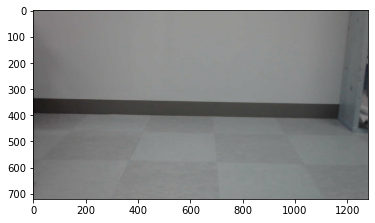

In [55]:
plt.imshow(frame)

## 원본 

In [57]:

# 비디오 열기
cap = cv2.VideoCapture("./data/edgetest2/lightall.mp4")

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # 'mp4v' 코덱 사용
out = cv2.VideoWriter('./data/edgetest2/output.mp4', fourcc, 20.0, (1280,720))


# Lucas-Kanade 파라미터 설정
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# 첫 번째 프레임에서 코너 검출
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=100, qualityLevel=0.01, minDistance=30)



while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 옵티컬 플로우 계산
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # 좋은 코너점 선택
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    
    # 삼각측량 수행
    points_4d_hom = cv2.triangulatePoints(P1, P2, good_old.T, good_new.T)
    points_3d = points_4d_hom / points_4d_hom[3]
    points_3d = points_3d[:3].T
    
    
    # 동차 좌표에서 일반 좌표로 변환
    points_3d = points_4d_hom / points_4d_hom[3]
    points_3d = points_3d[:3].T
    
    
    # 중심 좌표(0, 0, 0)를 2D로 투영
    center_point_3d = np.array([[0.0, 0.0, 0.0]])
    center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


    # 3D 점을 2D로 투영
    points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]
    
    edges = calculate_weighted_gradient(frame)
    edges = cv2.cvtColor(edges ,cv2.COLOR_GRAY2BGR)
    
    # 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
    for i, point in enumerate(points_2d):
        x, y = int(point[0][0]), int(point[0][1])
        cv2.circle(edges, (x, y), 5, (0, 255, 0), -1)

        # 3D 좌표 텍스트로 표시
        text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
        cv2.putText(edges, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
    cv2.circle(edges, (x_center, y_center), 5, (0, 0, 255), -1)
    cv2.putText(edges, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    out.write(edges)
    
#     # 코너점 시각화
#     for i, (new, old) in enumerate(zip(good_new, good_old)):
#         a, b = new.ravel()
#         c, d = old.ravel()
#         cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
#         cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    cv2.imshow('frame', edges)

    # 다음 반복을 위해 현재 상태 업데이트
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
out.release()
cap.release()
cv2.destroyAllWindows()


In [59]:

# 비디오 열기
cap = cv2.VideoCapture("./data/edgetest/light_flash.mp4")

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # 'mp4v' 코덱 사용
out = cv2.VideoWriter('./data/edgetest/output.mp4', fourcc, 20.0, (1280,720))


# Lucas-Kanade 파라미터 설정
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# 첫 번째 프레임에서 코너 검출
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=100, qualityLevel=0.01, minDistance=30)



while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 옵티컬 플로우 계산
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # 좋은 코너점 선택
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    
    # 삼각측량 수행
    points_4d_hom = cv2.triangulatePoints(P1, P2, good_old.T, good_new.T)
    points_3d = points_4d_hom / points_4d_hom[3]
    points_3d = points_3d[:3].T
    
    
    # 동차 좌표에서 일반 좌표로 변환
    points_3d = points_4d_hom / points_4d_hom[3]
    points_3d = points_3d[:3].T
    
    
    # 중심 좌표(0, 0, 0)를 2D로 투영
    center_point_3d = np.array([[0.0, 0.0, 0.0]])
    center_point_2d = cv2.projectPoints(center_point_3d, R, t, K, None)[0]


    # 3D 점을 2D로 투영
    points_2d = cv2.projectPoints(points_3d, R, t, K, None)[0]
    
    edges = calculate_weighted_gradient(frame)
    edges = cv2.cvtColor(edges ,cv2.COLOR_GRAY2BGR)
    
    # 2D 투영 점을 이미지에 표시하고, 해당 점의 3D 좌표를 텍스트로 추가
    for i, point in enumerate(points_2d):
        x, y = int(point[0][0]), int(point[0][1])
        cv2.circle(edges, (x, y), 5, (0, 255, 0), -1)

        # 3D 좌표 텍스트로 표시
        text = f"({points_3d[i][0]:.2f}, {points_3d[i][1]:.2f}, {points_3d[i][2]:.2f})"
        cv2.putText(edges, text, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    x_center, y_center = int(center_point_2d[0][0][0]), int(center_point_2d[0][0][1])
    cv2.circle(edges, (x_center, y_center), 5, (0, 0, 255), -1)
    cv2.putText(edges, "Center (0, 0, 0)", (x_center + 10, y_center), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    out.write(edges)
    
#     # 코너점 시각화
#     for i, (new, old) in enumerate(zip(good_new, good_old)):
#         a, b = new.ravel()
#         c, d = old.ravel()
#         cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
#         cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    cv2.imshow('frame', edges)

    # 다음 반복을 위해 현재 상태 업데이트
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
out.release()
cap.release()
cv2.destroyAllWindows()


## 정확도 판별 

In [60]:
im1 = cv2.imread("./data/testimg/WIN_20231220_18_12_49_Pro.jpg")
im2 = cv2.imread("./data/testimg/WIN_20231220_18_13_20_Pro.jpg")
im3 = cv2.imread("./data/testimg/WIN_20231220_18_13_35_Pro.jpg")
im4 = cv2.imread("./data/testimg/WIN_20231220_18_13_52_Pro.jpg")
im5 = cv2.imread("./data/testimg/WIN_20231220_18_14_37_Pro.jpg")
im6 = cv2.imread("./data/testimg/WIN_20231220_18_15_09_Pro.jpg")
im7 = cv2.imread("./data/testimg/WIN_20231220_18_15_27_Pro.jpg")
im8 = cv2.imread("./data/testimg/WIN_20231220_18_15_54_Pro.jpg")


In [83]:
def calculate_metrics(gt, edge_detected):
    TP = np.sum((gt == 255) & (edge_detected == 255))
    FP = np.sum((gt == 0) & (edge_detected == 255))
    FN = np.sum((gt == 255) & (edge_detected == 0))
    print(f"TP :{TP}, FP :{FP}, FN :{FN}")
    # 실제 에지 중에서 에지 검출 알고리즘이 올바르게 식별한 에지의 비율
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    # 알고리즘이 '에지'라고 분류한 것들 중 실제로 에지인 것의 비율
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0

    return recall, precision

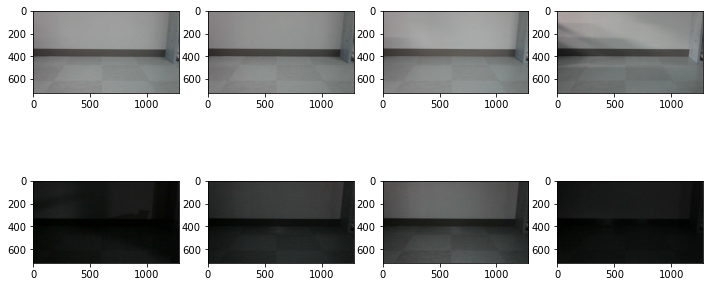

In [88]:

plt.figure(figsize=(12, 12))
plt.subplot(4,4,1)
plt.imshow(im1, cmap='gray')

plt.subplot(4,4,2)
plt.imshow(im2, cmap='gray')

plt.subplot(4,4,3)
plt.imshow(im3, cmap='gray')

plt.subplot(4,4,4)
plt.imshow(im4, cmap='gray')

plt.subplot(4,4,5)
plt.imshow(im5, cmap='gray')

plt.subplot(4,4,6)
plt.imshow(im6, cmap='gray')

plt.subplot(4,4,7)
plt.imshow(im7, cmap='gray')

plt.subplot(4,4,8)
plt.imshow(im8, cmap='gray')

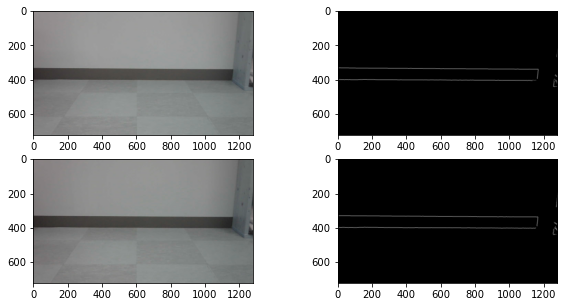

In [103]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
plt.imshow(im1, cmap='gray')

plt.subplot(2,2,2)
plt.imshow(edge1, cmap='gray')

plt.subplot(2,2,3)
plt.imshow(im2, cmap='gray')

plt.subplot(2,2,4)
plt.imshow(edge2, cmap='gray')

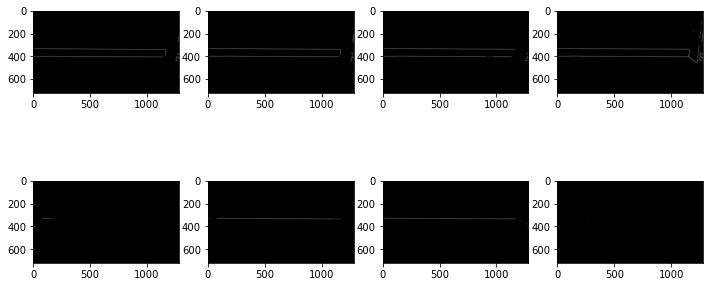

In [134]:
plt.figure(figsize=(12, 12))
plt.subplot(4,4,1)
plt.imshow(edge1, cmap='gray')

plt.subplot(4,4,2)
plt.imshow(edge2, cmap='gray')

plt.subplot(4,4,3)
plt.imshow(edge3, cmap='gray')

plt.subplot(4,4,4)
plt.imshow(edge4, cmap='gray')

plt.subplot(4,4,5)
plt.imshow(edge5, cmap='gray')

plt.subplot(4,4,6)
plt.imshow(edge6, cmap='gray')

plt.subplot(4,4,7)
plt.imshow(edge7, cmap='gray')

plt.subplot(4,4,8)
plt.imshow(edge8, cmap='gray')

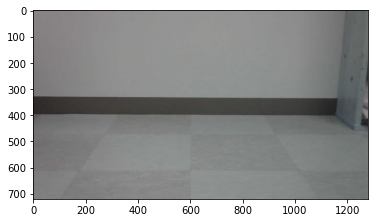

In [75]:
plt.imshow(im2)

In [84]:
edge1 = calculate_weighted_gradient(im1)
edge2 = calculate_weighted_gradient(im2)
edge3 = calculate_weighted_gradient(im3)
edge4 = calculate_weighted_gradient(im4)
edge5 = calculate_weighted_gradient(im5)
edge6 = calculate_weighted_gradient(im6)
edge7 = calculate_weighted_gradient(im7)
edge8 = calculate_weighted_gradient(im8)

print(calculate_metrics(edge4, edge1))
print(calculate_metrics(edge4, edge2))
print(calculate_metrics(edge4, edge3))
print(calculate_metrics(edge4, edge4))
print(calculate_metrics(edge4, edge5))
print(calculate_metrics(edge4, edge6))
print(calculate_metrics(edge4, edge7))
print(calculate_metrics(edge4, edge8))

TP :949, FP :4108, FN :5076
(0.15751037344398341, 0.18766066838046272)
TP :1663, FP :3470, FN :4362
(0.27601659751037344, 0.32398207675823104)
TP :2691, FP :2146, FN :3334
(0.44663900414937757, 0.5563365722555302)
TP :6025, FP :0, FN :0
(1.0, 1.0)
TP :15, FP :149, FN :6010
(0.0024896265560165973, 0.09146341463414634)
TP :116, FP :2052, FN :5909
(0.019253112033195022, 0.05350553505535055)
TP :415, FP :1928, FN :5610
(0.06887966804979254, 0.17712334613743064)
TP :0, FP :13, FN :6025
(0.0, 0.0)


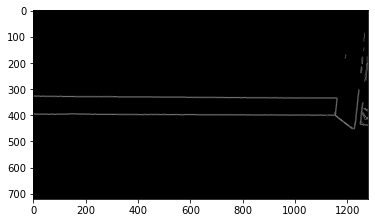

In [80]:
plt.imshow(edge4, cmap='gray')

In [82]:
def auto_canny(img, sigma=0.33) : 
    img = cv2.GaussianBlur(img, (5, 5), 0)
    v = np.median(img)
#     print(f"Average brightness:{np.mean(img):.2f}") # 평균 밝기 계산 
#     print(f"Bright Contrast:{np.std(img):.2f}") # 대조 값
    lower = int(max(0, 1.0 - sigma)*v)
    upper = int(min(255, (1.0 + sigma)*v ))
#     print(f"Threshold (lower) {lower} (upper) {upper}")
    edged = cv2.Canny(img, lower, upper)
    return edged

edge1 = auto_canny(im1)
edge2 = auto_canny(im2)
edge3 = auto_canny(im3)
edge4 = auto_canny(im4)
edge5 = auto_canny(im5)
edge6 = auto_canny(im6)
edge7 = auto_canny(im7)
edge8 = auto_canny(im8)

print(calculate_metrics(edge4, edge1))
print(calculate_metrics(edge4, edge2))
print(calculate_metrics(edge4, edge3))
print(calculate_metrics(edge4, edge4))
print(calculate_metrics(edge4, edge5))
print(calculate_metrics(edge4, edge6))
print(calculate_metrics(edge4, edge7))
print(calculate_metrics(edge4, edge8))

(0.0007457121551081282, 0.000471253534401508)
(0.23117076808351977, 0.13759431868619618)
(0.5212527964205816, 0.5715453802125919)
(1.0, 1.0)
(0.08277404921700224, 0.005784865540963102)
(0.015659955257270694, 0.013779527559055118)
(0.006711409395973154, 0.007328990228013029)
(0.00820283370618941, 0.0014852822036186875)


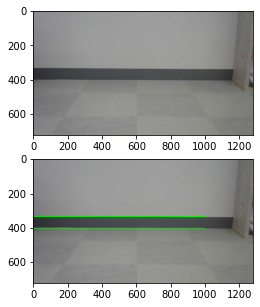

In [148]:
im1 = cv2.imread("./data/testimg/WIN_20231220_18_12_49_Pro.jpg")

plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge1, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im1, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im1, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

plt.show()

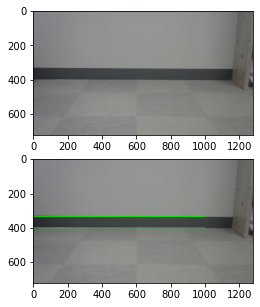

In [149]:
im2 = cv2.imread("./data/testimg/WIN_20231220_18_13_20_Pro.jpg")

plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge2, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im2, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im2, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

plt.show()

In [150]:
blue1, green1, red1 = cv2.split(im1)
blue2, green2, red2 = cv2.split(im2)

calculate_metrics(green1, green2)


TP :6002, FP :0, FN :0


(1.0, 1.0)

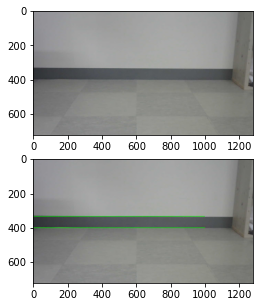

In [151]:
im3 = cv2.imread("./data/testimg/WIN_20231220_18_13_35_Pro.jpg")

plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge3, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im3, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im3, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))

plt.show()

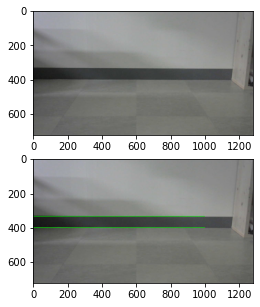

In [152]:
im4 = cv2.imread("./data/testimg/WIN_20231220_18_13_52_Pro.jpg")


plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im4, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge4, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im4, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im4, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im4, cv2.COLOR_BGR2RGB))

plt.show()

In [153]:
blue3, green3, red3 = cv2.split(im3)
blue4, green4, red4 = cv2.split(im4)


print(calculate_metrics(green1, green3))
print(calculate_metrics(green1, green4))

TP :4001, FP :0, FN :0
(1.0, 1.0)
TP :3001, FP :0, FN :0
(1.0, 1.0)


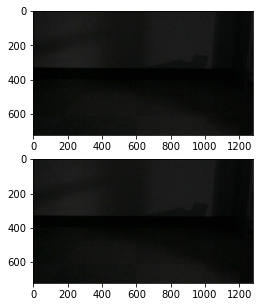

In [154]:
im5 = cv2.imread("./data/testimg/WIN_20231220_18_14_37_Pro.jpg")


plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im5, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge5, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im5, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im5, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im5, cv2.COLOR_BGR2RGB))

plt.show()

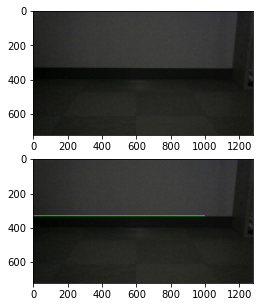

In [158]:
im6 = cv2.imread("./data/testimg/WIN_20231220_18_15_09_Pro.jpg")


plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im6, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge6, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im6, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im6, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im6, cv2.COLOR_BGR2RGB))

plt.show()

In [161]:
green1

array([[141, 141, 141, ..., 114, 116, 118],
       [141, 141, 141, ..., 114, 116, 118],
       [141, 141, 141, ..., 114, 116, 118],
       ...,
       [134, 134, 134, ..., 125, 125, 125],
       [134, 134, 134, ..., 125, 125, 125],
       [134, 134, 134, ..., 125, 125, 125]], dtype=uint8)

In [159]:
blue5, green5, red5 = cv2.split(im5)
blue6, green6, red6 = cv2.split(im6)


print(calculate_metrics(green1, green5))
print(calculate_metrics(green1, green6))

TP :0, FP :0, FN :68
(0.0, 0)
TP :1000, FP :0, FN :0
(1.0, 1.0)


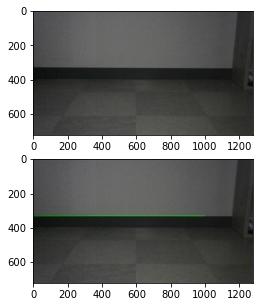

In [165]:
im7 = cv2.imread("./data/testimg/WIN_20231220_18_15_27_Pro.jpg")

plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im7, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge7, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im7, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im7, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im7, cv2.COLOR_BGR2RGB))

plt.show()

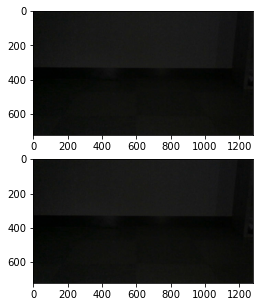

In [167]:
im8 = cv2.imread("./data/testimg/WIN_20231220_18_15_54_Pro.jpg")

plt.figure(figsize=(10,5))

plt.subplot(211)
plt.imshow(cv2.cvtColor(im8, cv2.COLOR_BGR2RGB))

lines = cv2.HoughLines(edge8, 1, np.pi / 180, threshold=250)

horizontal_lines = []
vertical_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # 각도를 기준으로 수평선과 수직선을 분류
        if theta < np.pi / 4 or theta > 3 * np.pi / 4:  # 수직선
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(im8, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif np.pi / 4 <= theta <= 3 * np.pi / 4:  # 수평선
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(im8, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(212)
plt.imshow(cv2.cvtColor(im8, cv2.COLOR_BGR2RGB))

plt.show()

In [168]:
blue7, green7, red7 = cv2.split(im7)
blue6, green6, red6 = cv2.split(im6)


print(calculate_metrics(green1, green7))
print(calculate_metrics(green1, green6))

TP :1000, FP :0, FN :0
(1.0, 1.0)
TP :1000, FP :0, FN :0
(1.0, 1.0)
